# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [29]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


## 2. Data Load

#### 2.1. 데이터 로드

In [31]:
import os
os.getcwd()

'/data/ephemeral/home/code'

In [9]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '../data/train.csv'
test_path  = '../data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [11]:
dt_test.shape
# dt['계약년월'].value_counts()

(9272, 52)

In [10]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1

concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [12]:
concat['is_test'].value_counts()

0    1118822
1       9272
Name: is_test, dtype: int64

In [13]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [14]:
# 주소로 unique id를 만들어봅니다

concat['본번'] = concat['본번'].fillna(-1)
concat['부번'] = concat['부번'].fillna(-1)

concat['본번'] = concat['본번'].astype(int).astype(str).replace({-1: np.nan})
concat['부번'] = concat['부번'].astype(int).astype(str).replace({-1: np.nan})

concat['지번_temp'] = concat['본번'] + '-' + concat['부번']

concat['번지'] = concat['번지'].fillna(concat['지번_temp'])
concat['번지'].isnull().sum()

concat = concat.drop('지번_temp', axis=1)

In [15]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat['본번'] = concat['본번'].astype('str')
concat['부번'] = concat['부번'].astype('str')


# '시군구'와 '번지'를 이용해 unique id를 만들어준다
concat['주소'] = concat['시군구'] + ' ' + concat['번지']

### xy좌표 결측치를 제거해봅니다

In [16]:
concat['is_test'].value_counts()

0    1118822
1       9272
Name: is_test, dtype: int64

In [190]:
concat_temp = concat

In [17]:
# xy좌표를 불러오고 unique id를 맞춰준다

coordinates = pd.read_csv('../data/xy좌표.csv', encoding='cp949')

coordinates['주소'] = coordinates['시군구'] + ' ' + coordinates['번지']

In [18]:
concat['is_test'].value_counts()

0    1118822
1       9272
Name: is_test, dtype: int64

In [207]:
coordinates['주소'].head()

0    서울특별시 금천구 독산동 1022-124
1    서울특별시 금천구 독산동 1022-120
2      서울특별시 종로구 창신동 595-99
3     서울특별시 종로구 창신동 595-247
4     서울특별시 금천구 독산동 1037-23
Name: 주소, dtype: object

In [ ]:
import pandasql as psql

# SQL 쿼리로 병합
query = """
SELECT concat.*, coordinates.x, coordinates.y
FROM concat
LEFT JOIN coordinates
ON concat.주소 = coordinates.주소
"""
result = psql.sqldf(query, locals())

print(result)

In [19]:
concat_temp = pd.merge(concat, coordinates, left_on='주소', right_on='주소', how='left', suffixes=('_A', '_B'))

# concat = concat_temp

concat_temp['is_test'].value_counts()
# concat = concat.drop(columns=['시군구_B', '번지_B'])

# concat = concat.rename(columns={'시군구_A':'시군구'})
# concat = concat.rename(columns={'번지_A':'번지'})

0    1131730
1       9390
Name: is_test, dtype: int64

### xy좌표 결측치 채우기(주소로 정렬한 후 선형보간으로 채우기)

In [182]:
concat['is_test'].value_counts()

0    1131730
1       9390
Name: is_test, dtype: int64

In [182]:
# xy좌표 결측치 채우기(주소로 정렬한 후 선형보간으로 채우기)

concat_sorted = concat.sort_values(by='주소')

# 연속형 변수에 대한 보간 (선형 보간)
col = ['x', 'y']
concat_sorted[col] = concat_sorted[col].interpolate(method='linear', axis=0)

concat = concat_sorted.sort_index()

In [183]:
concat['계약년월'] = concat['계약년월'].astype(str)

concat['계약년'] = concat['계약년월'].str[:4]
concat['계약월'] = concat['계약년월'].str[4:]

concat['계약년'] = concat['계약년'].astype(int)
concat['계약월'] = concat['계약월'].astype(int)

In [184]:
# 해제사유발생 = 1, 미발생 = 0 으로 바꾸기

concat['거래취소여부'] = concat['해제사유발생일'].notnull().astype(int)

concat['거래취소여부'].value_counts()

concat = concat.drop(columns = '해제사유발생일',  errors='ignore')

In [187]:
# 불필요한 컬럼 제거

drop_columns = ['아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지', '좌표X', '좌표Y','계약년월'
                'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-관리방식', 'k-난방방식', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
                'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', '단지승인일',
                'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '기타/의무/임대/임의=1/2/3/4', '사용허가여부', '관리비 업로드', '단지신청일'
                ]

concat = concat.drop(columns = drop_columns,  errors='ignore')

In [188]:
# 거래일 건물연식

concat['거래일건물연식'] = concat['계약년'] - concat['건축년도']

In [189]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat['구'] = concat['시군구'].map(lambda x : x.split()[1])
concat['동'] = concat['시군구'].map(lambda x : x.split()[2])
del concat['시군구']

# concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
# concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat['계약년월']

In [191]:
all = list(concat['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat['강남여부'] = is_gangnam

In [192]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
# 노후건축물 기준에 맞추어 거래일 기준 20년 미만일 시 신축으로 분류
concat['신축여부'] = concat['거래일건물연식'].apply(lambda x: 1 if x < 20 else 0)

In [ ]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

# concat.columns

In [194]:
concat.to_csv('../data/base_dataset.csv', index=False)

### 기본 데이터셋 정의

In [69]:
# 위 코드까지 실행할 결과를 새로운 기본 데이터셋으로 삼음
concat = pd.read_csv('../data/base_dataset.csv')

drop_col = ['k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-복도유형', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', '건축면적', '주차대수']

concat = concat.drop(columns = drop_col, errors = 'ignore')

### 빈 데이터를 채움

In [70]:
# 지번별 건물정보가 담긴 gis건물통합정보 파일을 불러와 데이터 병합하기

gis = pd.read_csv('../data/gis건물통합정보.csv')

drop_col = ['Unnamed: 0', '법정동명', '번지', '사용승인일자']
gis = gis.drop(columns = drop_col)

gis = gis.rename(columns={'ID':'주소'})

gis= gis.groupby('주소', as_index=False).agg({'건축면적': 'sum', '연면적': 'sum', '대지면적': 'sum', '건폐율': 'sum', '용적율': 'sum'})

gis.head()

,주소,건축면적,연면적,대지면적,건폐율,용적율
0,서울특별시 강남구 개포동 1055,507.18,11729.79,3017.0,16.81,51.99
1,서울특별시 강남구 개포동 1057-9,608.80,1359.20,3062.0,19.88,39.76
2,서울특별시 강남구 개포동 108,0.00,0.00,0.0,0.00,0.00
3,서울특별시 강남구 개포동 109,0.00,0.00,0.0,0.00,0.00
4,서울특별시 강남구 개포동 112-1,0.00,0.00,0.0,0.00,0.00


In [71]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# IterativeImputer 사용 보간
concat_temp = pd.merge(concat, gis, on='주소', how='left', suffixes=('_A', '_B'))
concat_temp.sort_values('주소')

col = ['건축면적', '연면적', '대지면적', '건폐율', '용적율']
concat_temp[col] = concat_temp[col].replace(0, np.nan)

imputer = IterativeImputer(max_iter=10, random_state=0)
concat_temp[col] = pd.DataFrame(imputer.fit_transform(concat_temp[col]), columns=[col])


concat_temp.sort_index()

concat = concat_temp

In [73]:
concat['거래취소여부'].astype(str)
concat['강남여부'].astype(str)
concat['층'].astype(str)
concat['본번'].astype(str)
concat['부번'].astype(str)

0          1
1          1
2          1
3          1
4          1
          ..
1141115    0
1141116    0
1141117    0
1141118    0
1141119    0
Name: 부번, Length: 1141120, dtype: object

In [74]:
# concat.to_csv('../data/base_dataset_1.csv', index=False)

### target값을 제곱미터당 가격으로 변경

In [112]:
concat = pd.read_csv('../data/base_dataset_1.csv')

In [113]:
# 평균층수 파생변수 추가
concat['평균층수'] = concat['연면적'] / concat['건축면적']

In [114]:
# target값을 평당 가격으로 바꿈 -> 최종 결과때 다시 new_target을 전용면적으로 곱하여 rmes구해야함

concat.rename(columns={'target': 'target_original'}, inplace=True)

concat['target'] = concat['target_original'] / concat['전용면적']

# concat.info()

In [115]:
concat = concat.drop(columns = 'target_original')

In [116]:
str_columns = ['본번', '부번', '거래취소여부', '구', '동', '강남여부', '신축여부']

concat[str_columns] = concat[str_columns].astype(str)

# concat.info()

In [117]:
# concat.to_csv('../data/base_dataset_2.csv', index=False)

In [46]:
# 인구증감율 or 인구수
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

population = pd.read_csv('../data/population.csv')

population['20대'] = population['20 - 24세'] + population['25 - 29세']
population['30대'] = population['30 - 34세'] + population['35 - 39세']
population['40대'] = population['40 - 44세'] + population['45 - 49세']

pop = population[['index', '20대', '30대', '40대']]
pop = pop.rename(columns = {'index': '계약년월'})
pop['계약년월'] = pop['계약년월'].astype(str)

pop['20대'] = pop['20대'].diff()
pop['30대'] = pop['30대'].diff()
pop['40대'] = pop['40대'].diff()

concat_temp = pd.merge(concat, pop, on='계약년월', how='left', suffixes=('_A', '_B'))


col = ['20대', '30대', '40대']

imputer = IterativeImputer(max_iter=10, random_state=0)
concat_temp[col] = pd.DataFrame(imputer.fit_transform(concat_temp[col]), columns=[col])

concat_temp.head()
concat = concat_temp

In [95]:
# 혼인율
marriage = pd.read_csv('../data/혼인율.csv')

marriage = marriage.T

marriage.columns = marriage.iloc[0]
marriage = marriage.drop(index='시군구별')

marriage = marriage.reset_index()
marriage = marriage[['index', '서울특별시']]

marriage['index'] = marriage['index'].str.replace('.', '')
marriage = marriage.rename(columns = {'index' : '계약년월', '서울특별시' : '혼인건수'})

marriage.head()

concat = pd.merge(concat, marriage, on='계약년월', how='left', suffixes=('_A', '_B'))

concat['혼인건수'] = concat['혼인건수'].astype(int)


In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

### dataset_2 시작

In [153]:
# concat = pd.read_csv('../data/base_dataset_2.csv')

In [6]:
concat1 = pd.read_csv('../data/base_dataset_3.csv')

In [5]:
concat['층'].value_counts()

 5     82748
 4     82633
 3     81089
 2     77575
 6     74215
       ...  
 68        6
 65        6
 67        6
-4         4
 69        2
Name: 층, Length: 73, dtype: int64

In [152]:
concat['계약월'] = concat['계약월'].astype(str).str.zfill(2)

In [153]:
# 금리데이터를 넣습니다

concat['계약년월'] = concat['계약년'].astype(str) + '' + concat['계약월'].astype(str)

interest = pd.read_csv('../data/한국기준금리07-23.csv')

interest['날짜'] = interest['날짜'].astype(str)
interest['계약년월'] = interest['날짜'].str[:6]
interest.drop(columns = '날짜', inplace = True)

In [154]:
# interest['계약년월'].fillna('-1')
# interest['계약년월'] = interest['계약년월'].astype(str)
concat['계약년월'] = concat['계약년월'].astype(str)

concat_temp = pd.merge(concat, interest, on='계약년월', how='left', suffixes=('_A', '_B'))

# concat_temp.drop(columns='계약년월', inplace=True)
concat = concat_temp

In [155]:
# 평형별로 초소형, 소형, 중형, 대형으로 분류

bins = [0, 26, 50, 60, 85, 245, float('inf')]
labels = [0, 1, 2, 3, 4, 5]

concat['면적분류'] = pd.cut(concat['전용면적'], bins=bins, labels=labels, right=False)

In [136]:
# 층 이상치 제거

train1 = concat.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
test1 = concat.query('is_test == 1')

train1 = train1[train1['층'] >= 1]

# 거래일 건물연식 이상치 제거
train1 = train1[train1['거래일건물연식'] >= 0]

# 옛날 계약 데이터 삭제 - 12년도 이전 삭제해봄
train1 = train1[train1['계약년'] >= 2012]

# 건축물 준공연도
concat = pd.concat([train1, test1])


In [156]:
concat['층'].value_counts()

 5     86440
 4     86244
 3     84754
 2     80999
 6     77372
       ...  
 68        6
 65        6
 67        6
-4         4
 69        2
Name: 층, Length: 73, dtype: int64

In [138]:
concat.loc[(concat['층'] < 1), '층'] = 1

In [137]:
#IQR 이상치 제거


# train1 = concat.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
# test1 = concat.query('is_test == 1')
def iqr_both(df, column_name):

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return df

def iqr_upper(df, column_name):

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] <= upper_bound)]

    return df

def iqr_lower(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR

    df = df[(df[column_name] >= lower_bound)]

    return df


train1 = iqr_upper(train1, '연면적')
train1 = iqr_lower(train1, '계약년')
# train1 = iqr_both(train1, 'target')s

# concat = pd.concat([train1, test1])
train1['계약년'].describe()

concat = pd.concat([train1, test1])

In [118]:
concat = concat[(concat['층'] >= 1) | (concat['is_test'] == 1)]

In [101]:
train1 = concat.query('is_test == 0') 
train1['층'].value_counts()

5     85880
4     85656
3     84226
2     80461
6     76773
      ...  
61        8
68        6
67        6
65        5
69        2
Name: 층, Length: 69, dtype: int64

In [140]:
pd.set_option('display.float_format', '{:.6f}'.format)

concat['층'].value_counts()

5     56924
4     56911
3     55697
2     53148
6     51402
      ...  
67        2
61        2
59        2
68        1
65        1
Name: 층, Length: 68, dtype: int64

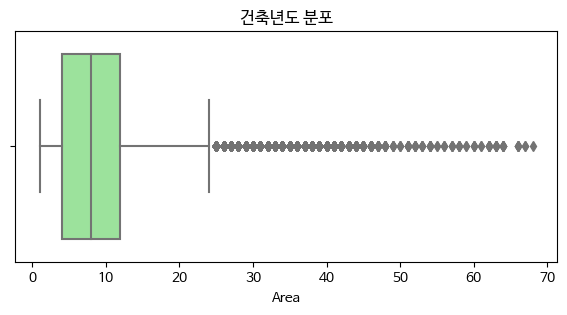

In [72]:
# 기타 이상치를 확인해봄

pd.set_option('display.float_format', '{:.6f}'.format)

concat['층'].describe()

fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = train1, x = '층', color='lightgreen')
plt.title('건축년도 분포')
plt.xlabel('Area')
plt.show()

In [ ]:
# sns.histplot(concat['연면적'], kde=True)
# plt.title('연면적')
# plt.xlabel('건축년도')
# plt.ylabel('year')
# plt.show()

In [58]:
concat.columns

Index(['번지', '본번', '부번', '전용면적', '계약일', '층', '건축년도', 'target', 'is_test', '주소',
       'x', 'y', '계약년', '계약월', '거래취소여부', '거래일건물연식', '구', '동', '강남여부', '신축여부',
       '건축면적', '연면적', '대지면적', '건폐율', '용적율', '평균층수', '계약년월', '기준금리', '면적분류'],
      dtype='object')

In [120]:
# 타임스플릿 전에 날짜별로 sorting해봄

concat.rename(columns={'계약년': 'year', '계약월': 'month', '계약일': 'day'}, inplace=True)
concat['계약날짜'] = pd.to_datetime(concat[['year', 'month', 'day']])

concat = concat.drop(['year', 'month', 'day'], axis=1)

# concat = concat.sort_values(by='계약날짜').reset_index(drop=True)

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
concat = pd.read_csv('../data/base_dataset_4.csv', index_col=None)

In [3]:
concat['is_test'].value_counts()

0    699179
1      9272
Name: is_test, dtype: int64

In [4]:
str_columns = ['본번', '부번', '거래취소여부', '구', '동', '강남여부', '신축여부', '계약년월', '면적분류']

concat[str_columns] = concat[str_columns].astype(str)
concat['면적분류'] = concat['면적분류'].astype(int)
# concat['계약월'] = concat['계약월'].astype(int)
concat['계약날짜'] = concat['계약날짜'].astype(str)

In [5]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat.columns:
    if pd.api.types.is_numeric_dtype(concat[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['Unnamed: 0', '전용면적', '층', '건축년도', 'target', 'is_test', 'x', 'y', '거래일건물연식', '건축면적', '연면적', '대지면적', '건폐율', '용적율', '평균층수', '기준금리', '면적분류']
범주형 변수: ['번지', '본번', '부번', '주소', '거래취소여부', '구', '동', '강남여부', '신축여부', '계약년월', '계약날짜']


In [ ]:

drop_col = ['Unnamed: ', '본번', '부번', '번지', ]

concat.drop(columns=)

In [6]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [7]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
concat_select = remove_outliers_iqr(concat, '전용면적')

In [8]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

(699070, 27) (9272, 27)


In [16]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

연속형 변수: ['Unnamed: 0', '전용면적', '층', '건축년도', 'target', 'x', 'y', '거래일건물연식', '건축면적', '연면적', '대지면적', '건폐율', '용적율', '평균층수', '기준금리', '면적분류']
범주형 변수: ['번지', '본번', '부번', '주소', '거래취소여부', '구', '동', '강남여부', '신축여부', '계약년월', '계약날짜']


100%|██████████| 11/11 [00:02<00:00,  5.22it/s]


In [17]:
from sklearn.model_selection import TimeSeriesSplit

In [18]:
assert dt_train.shape[1] == dt_test.shape[1] 

# Target과 독립변수들을 분리합니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# TimeSeriesSplit을 통해 학습/검증 데이터로 나눔
for train_index, val_index in tscv.split(X_train):
    X_train_1, X_val_1 = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_1, y_val_1 = y_train.iloc[train_index], y_train.iloc[val_index]

In [90]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2024)

In [245]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [246]:
y_val = y_val * X_val['전용면적']
pred = pred * X_val['전용면적']

In [247]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 4769.639578755779


In [19]:
#  XGBoost 사용

import xgboost as xgb

In [20]:
model = xgb.XGBRegressor(objective='reg:squarederror', 
                         n_estimators=1000,  
                         learning_rate=0.1,  
                         max_depth=10,
                         random_state=1)

model.fit(X_train_1, y_train_1)

pred = model.predict(X_val_1)

# y_val_2 = y_val_1 * X_val_1['전용면적']
# pred_2 = pred * X_val_1['전용면적']

In [79]:
type(model)

xgboost.sklearn.XGBRegressor

In [21]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val_1, pred))}')

RMSE test: 3010.7670749227054


- 변수 중요도도 확인해보도록 하겠습니다.

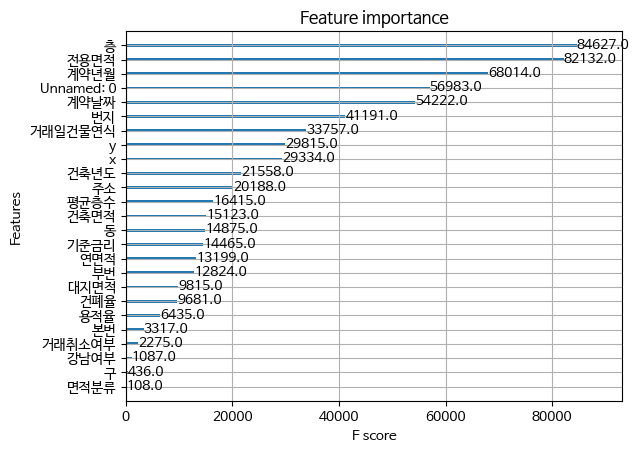

In [26]:
xgb.plot_importance(model)
plt.show()

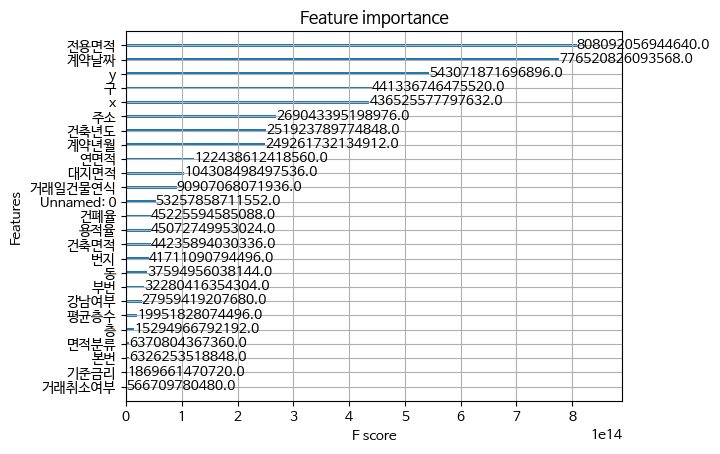

In [24]:
xgb.plot_importance(model, importance_type='total_gain')
plt.show()

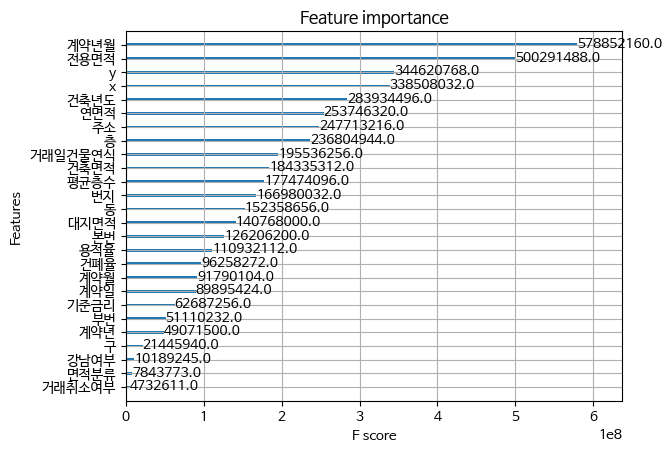

In [33]:
xgb.plot_importance(model, importance_type='total_cover')
plt.show()


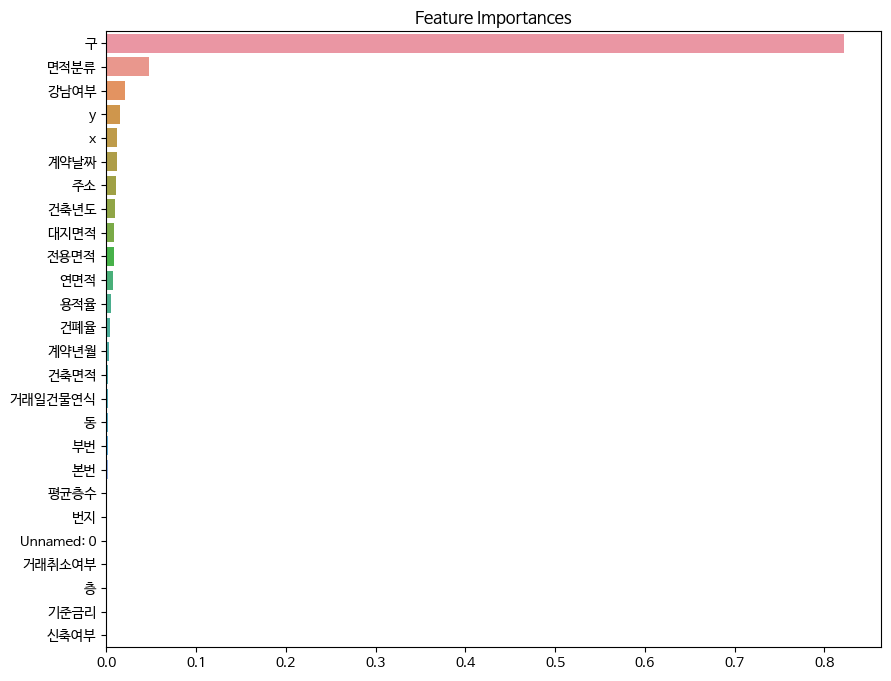

In [27]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [42]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('./temp/saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [30]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val_1, y_val_1)
eli5.show_weights(perm, feature_names = X_val_1.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
163691237.3944 ± 991818.5707,전용면적
156882247.4341 ± 1389089.4627,y
70462396.2692 ± 385195.1738,x
46885859.5093 ± 1064048.1831,구
41426084.1838 ± 442003.0405,건축년도
23351111.7542 ± 190353.0003,주소
10631906.3862 ± 76894.2714,연면적
6830699.6280 ± 133612.6366,거래일건물연식
5044042.1262 ± 76370.0489,건축면적
4410679.0537 ± 39411.1539,동


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [31]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val_1['target'] = y_val_1
X_val_1['pred'] = pred

In [32]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val_1['target'], X_val_1['pred'])
X_val_1['error'] = squared_errors

In [33]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val_1.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [34]:
X_val_sort.head()

,Unnamed: 0,번지,본번,부번,전용면적,층,건축년도,주소,x,y,...,건폐율,용적율,평균층수,계약년월,기준금리,면적분류,계약날짜,target,pred,error
640384,852135,2812,801,1,114.96,5,1994,6742,126.954929,37.525218,...,94.940000,1587.300000,4.819031,21,2.50,4,659,150500.0,88164.414062,3.885725e+09
619598,826736,4821,1222,1,107.47,1,1973,4743,126.989036,37.505354,...,295.753665,3116.907864,5.160202,28,2.50,4,871,120000.0,181089.218750,3.731893e+09
644300,856879,1615,576,1,115.04,7,2010,7631,126.980637,37.559126,...,52.810000,970.680000,29.504687,24,2.50,4,752,37500.0,95000.773438,3.306339e+09
649469,863031,3665,971,1,106.22,9,1981,323,127.044063,37.529126,...,297.238369,3138.077428,12.631906,15,2.75,4,455,60771.0,116362.835938,3.090452e+09
649549,863181,3396,904,1,111.50,9,1980,317,127.035440,37.531214,...,299.934718,3177.075452,11.455064,13,2.75,4,423,160000.0,105394.289062,2.981784e+09


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [36]:
X_val_sort_top100 = X_val_1.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val_1.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [37]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [39]:
display(error_top100.head())
display(best_top100.head())

,Unnamed: 0,번지,본번,부번,전용면적,층,건축년도,주소,x,y,...,건폐율,용적율,평균층수,계약년월,기준금리,면적분류,계약날짜,target,pred,error
640384,852135,395,395,0,114.96,5,1994,서울특별시 용산구 이촌동 395,126.954929,37.525218,...,94.940000,1587.300000,4.819031,201310,2.50,4,2013-10-22,150500.0,88164.414062,3.885725e+09
619598,826736,757,757,0,107.47,1,1973,서울특별시 서초구 반포동 757,126.989036,37.505354,...,295.753665,3116.907864,5.160202,201405,2.50,4,2014-05-22,120000.0,181089.218750,3.731893e+09
644300,856879,206,206,0,115.04,7,2010,서울특별시 중구 회현동1가 206,126.980637,37.559126,...,52.810000,970.680000,29.504687,201401,2.50,4,2014-01-23,37500.0,95000.773438,3.306339e+09
649469,863031,528,528,0,106.22,9,1981,서울특별시 강남구 압구정동 528,127.044063,37.529126,...,297.238369,3138.077428,12.631906,201304,2.75,4,2013-04-01,60771.0,116362.835938,3.090452e+09
649549,863181,481,481,0,111.50,9,1980,서울특별시 강남구 압구정동 481,127.035440,37.531214,...,299.934718,3177.075452,11.455064,201302,2.75,4,2013-02-28,160000.0,105394.289062,2.981784e+09


,Unnamed: 0,번지,본번,부번,전용면적,층,건축년도,주소,x,y,...,건폐율,용적율,평균층수,계약년월,기준금리,면적분류,계약날짜,target,pred,error
687691,907532,119-27,119,27,52.090,10,2012,서울특별시 송파구 오금동 119-27,127.139334,37.503325,...,28.870000,199.580000,6.913789,201304,2.75,2,2013-04-16,34500.0,34502.367188,5.603577
582654,784725,1461,1461,0,49.560,10,1992,서울특별시 강서구 가양동 1461,126.847174,37.570495,...,238.400000,1991.520000,8.731474,201403,2.50,1,2014-03-20,24000.0,23997.666016,5.447483
665594,881769,941,941,0,84.917,7,2005,서울특별시 노원구 월계동 941,127.058919,37.623149,...,296.450284,3126.854555,10.611010,201304,2.75,3,2013-04-24,32000.0,32002.322266,5.392918
592282,795944,478,478,0,84.960,12,2000,서울특별시 구로구 개봉동 478,126.851940,37.484679,...,303.243645,3223.830461,14.299859,201409,2.50,3,2014-09-20,32000.0,31997.728516,5.159641
585182,787653,685,685,0,84.830,7,2004,서울특별시 강서구 내발산동 685,126.832029,37.553675,...,27.100000,249.750000,11.765541,201409,2.50,3,2014-09-17,35000.0,34997.792969,4.870987


- 이제 분포를 비교해보도록 하겠습니다.

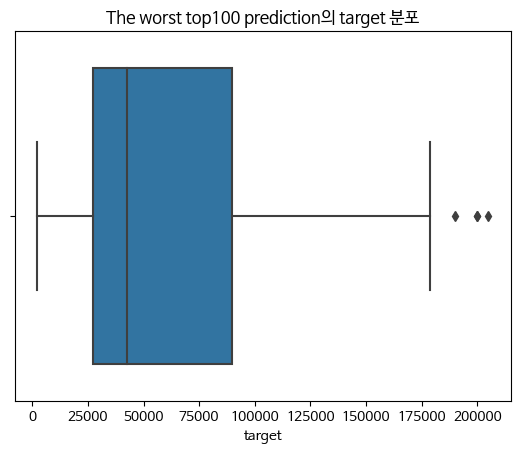

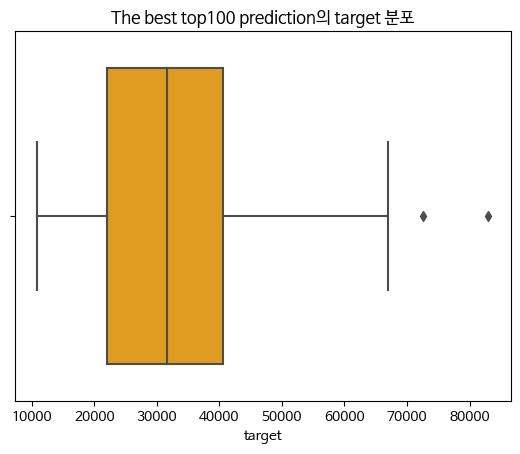

In [40]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

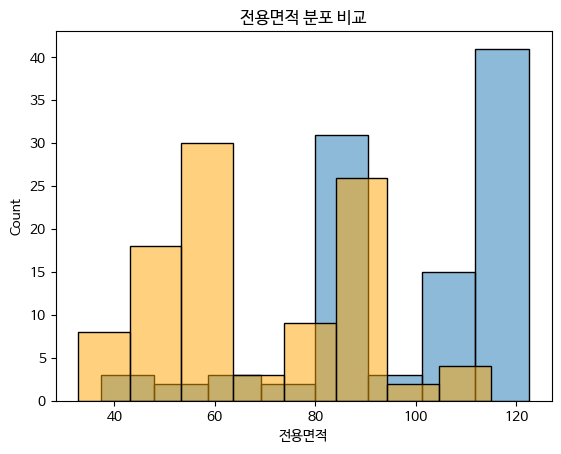

In [41]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [80]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,번지,본번,부번,전용면적,계약일,층,건축년도,주소,x,y,...,건축면적,연면적,대지면적,건폐율,용적율,평균층수,target,계약년월,기준금리,면적분류
1179487,4284,1115,2,79.9700,26,5,1987,32,127.056841,37.476283,...,4551.3300,22305.9300,171124.438613,297.162458,3139.237949,4.90097,0,198,3.5,3
1179488,4260,1108,2,108.2017,15,10,2021,25,127.057251,37.484828,...,2706.0317,31893.0189,164008.524870,297.009766,3135.924895,11.78590,0,199,3.5,4


In [56]:
dt_test1.head(2)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.9700,202307,26,5,1987,...,직영,4858.00,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.057210,37.476763,2022-11-17 10:19:06.0
1,서울특별시 강남구 개포동,651-1,651.0,1.0,개포더샵트리에,108.2017,202308,15,10,2021,...,위탁,2724.46,305.0,의무,2022-02-23 13:01:10.0,Y,N,127.056394,37.484892,2022-02-23 11:05:05.0


In [43]:
# 저장된 모델을 불러옵니다.
with open('./temp/saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [97]:
type(model)

xgboost.sklearn.XGBRegressor

In [45]:
dt_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9272 entries, 699179 to 708450
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  9272 non-null   int64  
 1   번지          9272 non-null   int64  
 2   본번          9272 non-null   int64  
 3   부번          9272 non-null   int64  
 4   전용면적        9272 non-null   float64
 5   층           9272 non-null   int64  
 6   건축년도        9272 non-null   int64  
 7   target      9272 non-null   int64  
 8   주소          9272 non-null   int64  
 9   x           9272 non-null   float64
 10  y           9272 non-null   float64
 11  거래취소여부      9272 non-null   int64  
 12  거래일건물연식     9272 non-null   int64  
 13  구           9272 non-null   int64  
 14  동           9272 non-null   int64  
 15  강남여부        9272 non-null   int64  
 16  신축여부        9272 non-null   int64  
 17  건축면적        9272 non-null   float64
 18  연면적         9272 non-null   float64
 19  대지면적        9272 non

In [44]:
dt_test.head()

,Unnamed: 0,번지,본번,부번,전용면적,층,건축년도,target,주소,x,...,건축면적,연면적,대지면적,건폐율,용적율,평균층수,계약년월,기준금리,면적분류,계약날짜
699179,1165613,4245,1113,2,79.9700,5,1987,0,32,127.056841,...,4551.3300,22305.9300,171357.334166,297.555783,3143.834230,4.900970,138,3.5,3,4190
699180,1165614,4221,1106,2,108.2017,10,2021,0,25,127.057251,...,2706.0317,31893.0189,164240.992757,297.402886,3140.519263,11.785900,139,3.5,4,4210
699181,1165615,4222,1107,1,161.0000,15,1984,0,26,127.056014,...,4484.9400,61999.0800,183006.694768,299.033944,3163.697455,13.823837,138,3.5,4,4192
699182,1165616,4222,1107,1,133.4600,14,1984,0,26,127.056014,...,4484.9400,61999.0800,183006.694768,299.033944,3163.697455,13.823837,139,3.5,4,4205
699183,1165617,4222,1107,1,104.4300,6,1984,0,26,127.056014,...,4484.9400,61999.0800,183006.694768,299.033944,3163.697455,13.823837,139,3.5,4,4213


In [99]:
print(real_test_pred.shape)
print(dt_test['전용면적'].shape)

(9390,)
(9390,)


In [46]:
%%time
X_test = dt_test.drop(['target'], axis=1)

real_test_pred = model.predict(X_test)
# real_test_pred = real_test_pred * dt_test['전용면적'].values

CPU times: user 530 ms, sys: 83 µs, total: 530 ms
Wall time: 65.3 ms


In [47]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([187669.66, 265536.3 , 235682.11, ...,  86014.62,  71421.03,
        75809.2 ], dtype=float32)

In [48]:
plt.hist(dt['전용면적'], bins=50, alpha=0.5, label='Train')
plt.hist(dt_test['전용면적'], bins=50, alpha=0.5, label='Test')
plt.legend()
plt.show()

NameError: name 'dt' is not defined

## 7. Output File Save

In [49]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('./temp/output.csv', index=False)